## Guided Project on IBM Skills Network

# Predict the stock market using weather data

## Task
Forecast the Dow Jones Industrial Average index (DJI) using lagged prices and weather data from New York City.

## Background
A potential driving factor of stock prices is the current weather in New York City, a global financial hub and the physical location of the stock exchange where constituent stocks of the Dow Jones Industrial Average index (DJI) are traded. You hypothesize that the mood of traders and investors in New York City is influenced by weather conditions, impacting trade patterns and consequently, stock prices. Your theory suggests potential correlations, such as traders being more inclined to buy during favorable weather and sell during gloomy conditions. To validate this hypothesis, you aim to test if New York's weather patterns account for some of the variation in stock prices. Additionally, you aim to explore whether these weather patterns could be used to enhance the predictive power of forecasting models.

You understand that the stock market reflects the decisions of millions of investors responding to vast amounts of information, of which the weather in New York City is just one example. You understand that the stock market is inherently very difficult to predict, and you will be satisfied with any result that shows a causal or predictive link between weather patterns and stock prices.

## Disclaimer
This project is designed solely for educational purposes. It does not offer or imply any financial advice. If you decide to make investment decisions based on the information or insights gained from this project, you are doing so at your own risk.


---


# Objectives

After completing this lab you will be able to:

- Perform time series analysis, avoiding common pitfalls and traps
  - Manage and manipulate time series data
  - Conduct exploratory data analysis (EDA)
  - Handle missing data in time series contexts
  - Perform feature engineering for time series analysis
  - Address seasonality in time series data
  - Test for and ensure stationarity
  - Construct models for time series forecasting
  - Evaluate the performance of time series models using cross-validation
  - Use a variety of models for time series prediction tasks, including:
    - Linear regression
    - ARIMA/ARMA/ARMAX/ARIMAX/SARIMAX
    - Random forest regression


---


# Setup


For this project, we will be using the following libraries:

*   [`pandas`](https://pandas.pydata.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for managing the data.
*   [`numpy`](https://numpy.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for mathematical operations.
*   [`scipy`](https://scipy.org/) for scientific and statistical computing capabilities.
*   [`sklearn`](https://scikit-learn.org/stable/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for machine learning and machine-learning-pipeline related functions.
*   [`statsmodels`](https://www.statsmodels.org/stable/index.html) for performing statistical analysis, including regression.
*   [`seaborn`](https://seaborn.pydata.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for visualizing the data.
*   [`matplotlib`](https://matplotlib.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for additional plotting tools.
*   [`tqdm`](https://tqdm.github.io/) for providing progress bars to Python loops.


## Install required libraries


In [ ]:
%%capture
%pip install tqdm
%pip install seaborn
%pip install skillsnetwork
%pip install scikit-learn==0.24
%pip install statsmodel
%pip install sklearn

## Import required libraries


In [ ]:
from functools import reduce
from copy import deepcopy
import tqdm
import numpy as np
from scipy.signal import periodogram
from scipy.stats import binomtest
import pandas as pd
import skillsnetwork
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
%matplotlib inline

# Float format for pandas display
pd.set_option('display.float_format', lambda x: '%.8f' % x)

# Suppress unneeded warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

sns.set_context('notebook')
sns.set(style="darkgrid")

---


## Import datasets

The weather dataset used in this guided project is sourced from the  <a href="https://www.ncei.noaa.gov/products/land-based-station/integrated-surface-database">Integrated Surface Database (ISD)</a> database provided by  <a href="https://www.noaa.gov/">NOAA</a>. This dataset contains weather observations for LaGuardia, the nearest airport to Manhattan, spanning from mid-1948 to the end of 2023.

The DJI data comes from <a href="http://www.econstats.com">econstats.com</a> and is available <a href="http://www.econstats.com/eqty/eq_d_na_4.csv">here</a>.


In [ ]:
# Import weather data
# Note that all of the columns are imported as strings
# This is generally the safest option, but requires additional processing later on

await skillsnetwork.download_dataset(
    'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-GPXX0K1YEN/laguardia.csv'
)
laguardia = pd.read_csv('laguardia.csv', dtype='str')

# Import DOW Jones Industrial Average historical data

await skillsnetwork.download_dataset(
    'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-GPXX0K1YEN/dow_jones.csv'
)
dow = pd.read_csv('dow_jones.csv', dtype='str')

Saved as 'laguardia.csv'


Saved as 'dow_jones.csv'


In [ ]:
print("Laguardia table", "-")
laguardia.head()

Laguardia table -


,DATE,wind,dew_point,temp,pressure,cloud_cover
0,1948-07-01T11:00:00,3.1,20.6,22.8,1015.6,1.0
1,1948-07-01T12:00:00,1.5,20.0,23.3,1015.9,0.875
2,1948-07-01T13:00:00,4.6,20.0,25.0,1016.3,0.25
3,1948-07-01T14:00:00,3.6,19.4,26.7,1016.3,0.0
4,1948-07-01T15:00:00,5.2,17.2,27.8,1016.3,0.0


In [ ]:
print("Dow table", "-")
dow.head()

Dow table -


,DATE,Open,High,Low,Close,Volume
0,2012-12-31,12938.2,13109.1,12883.9,13104.1,1457.4
1,2012-12-28,13095.1,13095.5,12926.9,12938.1,859.8
2,2012-12-27,13115,13141.7,12964.1,13096.3,1001.6
3,2012-12-26,13138.9,13174.9,13076.9,13114.6,794.1
4,2012-12-25,na,na,na,na,na


# Data preprocessing

## Convert columns to correct types

Firstly, ensure all columns are converted to the correct data types. Pay particular attention to the use of the `datetime` format, as it offers numerous useful methods for manipulating and organizing data in the time domain.


In [ ]:
# Weather data
laguardia['DATE'] = pd.to_datetime(laguardia.DATE)
laguardia[['wind',
           'dew_point',
           'temp', 'pressure',
           'cloud_cover']] = laguardia[['wind',
                                        'dew_point',
                                        'temp',
                                        'pressure',
                                        'cloud_cover']].astype(float)

# Market data
dow['DATE'] = pd.to_datetime(dow.DATE)
# Drop missing value rows
dow = dow.loc[dow.Open != '            na']
dow[[i for i in dow.columns if i != 'DATE']] = dow[[i for i in dow.columns if i != 'DATE']].astype(float)
dow['Volume'] = dow.Volume.astype(int)

For simplicity, we'll limit the analysis to the `temp` and `cloud_cover` columns in the weather dataset, and the `Close` column in the `dow` dataset.


In [ ]:
laguardia = laguardia.loc[:, ['DATE', 'temp', 'cloud_cover']]
dow = dow.loc[:, ['DATE', 'Close']]

## Exploratory data analysis (EDA)

Begin the analysis of any time series data by examining the `DATE` column. At this stage, the objective is to determine the resolution of the data.

The following code prints information about the `DATE` field in the `laguardia` dataset.


In [ ]:
# Print the `DATE` field in the `laguardia` dataset:
print("laguardia 'DATE' field head")
print(laguardia.DATE.head())

# The following code shows the hours for which data is available
print("\n laguardia 'DATE' field hour availability")
print(sorted(laguardia.DATE.dt.hour.unique()))

# The following code shows the minutes for which data is available
print("\n laguardia 'DATE' field minute availability")
print(sorted(laguardia.DATE.dt.minute.unique()))

laguardia 'DATE' field head
0   1948-07-01 11:00:00
1   1948-07-01 12:00:00
2   1948-07-01 13:00:00
3   1948-07-01 14:00:00
4   1948-07-01 15:00:00
Name: DATE, dtype: datetime64[ns]

 laguardia 'DATE' field hour availability
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]

 laguardia 'DATE' field minute availability
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]


The following code prints information about the DATE field in the laguardia dataset.


In [ ]:
# Print the `DATE` field in the `dow` dataset:
print("dow 'DATE' field head")
print(dow.DATE.head())

# The following code shows the hours for which data is available
print("\n dow 'DATE' field hour availability")
print(sorted(dow.DATE.dt.hour.unique()))

# The following code shows the minutes for which data is available
print("\n dow 'DATE' field minute availability")
print(sorted(dow.DATE.dt.minute.unique()))



dow 'DATE' field head
0   2012-12-31
1   2012-12-28
2   2012-12-27
3   2012-12-26
5   2012-12-24
Name: DATE, dtype: datetime64[ns]

 dow 'DATE' field hour availability
[0]

 dow 'DATE' field minute availability
[0]


---


Notice that the `laguardia` dataset contains observations not only for individual hours, but also for individual minutes. On the other hand, the `dow` dataset contains daily data because all observations occur on the zeroth hour and zeroth minute.

The above analysis raises questions about the `DATE` field in the `laguardia` dataset. The following code will show the frequency counts for the minutes of the hour for which data is available:


In [ ]:
# The following code shows the frequency counts for minutes in `laguardia`:
print("\n laguardia 'DATE' field minute frequency (head):")
print(laguardia.DATE.dt.minute.value_counts().head())


 laguardia 'DATE' field minute frequency (head):
DATE
0     503480
51    235096
59     10846
49      3229
30      1714
Name: count, dtype: int64


It is clear that the `laguardia` dataset does not contain evenly spaced data. Instead, there are numerous observations on the hour, on the 51st minute of the hour, and on the 59th minute of the hour. Additional observations are scattered throughout the remaining minutes.

The following code will now check to see if there are duplicated observations in the `laguardia` dataset:


In [ ]:
print("'laguardia' duplicated:")
print(laguardia.DATE.duplicated().value_counts())

'laguardia' duplicated:
DATE
False    799794
True       2145
Name: count, dtype: int64


The following code will now check to see if there are duplicated observations in the `dow` dataset:

In [ ]:
print("'dow' duplicated:")
print(dow.DATE.duplicated().value_counts())

'dow' duplicated:
DATE
False    20962
Name: count, dtype: int64


---


There are numerous duplicated observations for some timestamps in the `laguardia` dataset. On the other hand, the `dow` dataset does not contain any duplicates.

The following code will check for the existence of missing values in the <code>laguardia</code> dataset:


In [ ]:
print("'laguardia' missing:")
print(laguardia.isna().max())

'laguardia' missing:
DATE           False
temp            True
cloud_cover     True
dtype: bool



The following code will check for the existence of missing values in the `dow` dataset:

In [ ]:
print("'dow' missing:")
print(dow.isna().max())

'dow' missing:
DATE     False
Close    False
dtype: bool


---


All data columns in the `laguardia` dataset contain missing observations. On the other hand, there are no missing observations in the `dow` dataset.

The following code outlines the structure of the `laguardia` dataset, offering a comprehensive overview of the columns contained within:


In [ ]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
print("'laguardia' description:")
print(laguardia.describe())

'laguardia' description:
                                DATE      temp  cloud_cover
count                         801939 717298.00    646597.00
mean   1991-12-16 23:04:52.245719424     13.04         0.60
min              1948-07-01 11:00:00    -19.40         0.00
25%              1976-07-10 23:30:00      5.60         0.25
50%              1997-01-30 22:51:00     13.30         0.75
75%              2009-06-09 12:21:30     21.10         1.00
max              2023-12-31 23:51:00     39.40         1.00
std                              NaN      9.76         0.39


The following code outlines the structure of the `dow` dataset, offering a comprehensive overview of the columns contained within:

In [ ]:
print("'dow' description:")
print(dow.describe())
pd.set_option('display.float_format', lambda x: '%.8f' % x)

'dow' description:
                                DATE    Close
count                          20962 20962.00
mean   1970-08-01 08:56:18.456254148  2666.95
min              1928-10-03 00:00:00    41.22
25%              1949-09-26 06:00:00   249.71
50%              1970-09-10 12:00:00   843.64
75%              1991-06-06 18:00:00  2938.80
max              2012-12-31 00:00:00 14164.50
std                              NaN  3812.78


In [ ]:
print("Dow table")
dow.head()

Dow table


,DATE,Close
0,2012-12-31,13104.10000000
1,2012-12-28,12938.10000000
2,2012-12-27,13096.30000000
3,2012-12-26,13114.60000000
5,2012-12-24,13138.90000000


In [ ]:
print("Laguardia table")
laguardia.head()

Laguardia table


,DATE,temp,cloud_cover
0,1948-07-01 11:00:00,22.80000000,1.00000000
1,1948-07-01 12:00:00,23.30000000,0.87500000
2,1948-07-01 13:00:00,25.00000000,0.25000000
3,1948-07-01 14:00:00,26.70000000,0.00000000
4,1948-07-01 15:00:00,27.80000000,0.00000000


---


The `temp` column in the `laguardia` dataset contains temperature in Celsius, while the `cloud_cover` column contains the fraction of the sky covered by clouds in oktas. Here, 0/8 = 0 indicates no cloud cover, and 8/8 = 1 indicates complete cloud cover.

The `dow` dataset contains the closing price of the DJI index.

It is evident that the data merging process will be quite intricate. We're working with weather data that is duplicated, has data at odd minutes, and contains missing observations. This data must be merged with market data that follows a different&mdash;daily&mdash;resolution.


## Data cleaning and merging strategy

The first obstacle to overcome is the difference in data resolutions. It seems reasonable to resample the weather data to acquire daily data that can be effectively merged with the market dataset. The intuitive method involves averaging all daily observations, such as temperature readings, to yield one observation per day.

However, there are at least two issues with this strategy. Firstly, the dataset includes odd minutes, suggesting that some hours in a day might be oversampled compared to others, receiving higher weight when calculating the daily average. For example, consider a day that has temperature observations at 1:51, 2:00, 2:01, and 15:00. Averaging these would give three times the weight to observations around the 2:00 am mark compared to the 3:00 pm observation, biasing the estimate of the average temperature downwards, as nighttime temperatures are typically lower than daytime temperatures.

Another issue arises from domain knowledge and speculation on how New York's weather could influence the decision-making of investors and traders. It is improbable that the weather at 2:00 am the night before trading has as strong an impact as the 9:00 am weather on the day of trading. Most traders are likely to be asleep at 2:00 am but may be quite sensitive to weather conditions at 9:00 am, just 30 minutes before the market typically opens. This discussion highlights the importance of considering context and domain knowledge in data science techniques.

Certainly, a revised strategy for cleaning and merging the data is necessary to better align with the nature of the problem. The weather data will be resampled by averaging weather variables between 8 am and 9 am on each trading day because these weather readings precede actual market trading for that day (hence preserving the temporal precedence of the cause coming before the effect) and because traders are presumed to be most affected by morning weather as they commute to their respective offices.

The following four step process will clean the weather data and merge it with the `dow` dataset.


### Step 1: Resample weather data to an hourly resolution

In this initial step, the weather data will be resampled to an hourly frequency by calculating the average of all minutes that round to each respective hour. While acknowledging that this approach may lead to some minutes being overrepresented within each hour, it is considered acceptable as weather changes are not expected to vary significantly from one hour to the next. An alternative approach would involve discarding observations not taken precisely on the hour. However, this would result in numerous gaps in the dataset, with some hours lacking data despite having observations just minutes from the hour mark.


In [ ]:
# The following resamples all data to an hourly frequency by
# taking an average of all minutes that round to that hour.
laguardia['DATE'] = laguardia['DATE'].dt.round('60min')

# Note that a loop is used to account for the fact that each column contains a
# unique set of missing values:
laguardia_cols = []

for c in laguardia.columns:
    if c == 'DATE':
        continue
    else:
        laguardia_cols.append(
            laguardia[['DATE', c]].dropna().groupby(
                'DATE', as_index=False
            ).agg({c: 'mean'})
        )

# Finally, merge all columns back together again:
laguardia_merged = reduce(
    lambda left, right: pd.merge(left, right, on=['DATE'], how='outer'), laguardia_cols
)

# Sort by DATE
laguardia_merged.sort_values('DATE', inplace=True)

# Let's see what the merged data looks like:
laguardia_merged.head()

,DATE,temp,cloud_cover
0,1948-07-01 11:00:00,22.80000000,1.00000000
1,1948-07-01 12:00:00,23.30000000,0.87500000
2,1948-07-01 13:00:00,25.00000000,0.25000000
3,1948-07-01 14:00:00,26.70000000,0.00000000
4,1948-07-01 15:00:00,27.80000000,0.00000000


### Step 2: Deal with missing data

The resulting dataset still contains a lot of missing data:


In [ ]:
laguardia_merged.isna().value_counts()

DATE   temp   cloud_cover
False  False  False          569290
              True            44601
       True   False             184
Name: count, dtype: int64

How should the missing data be imputed? In non-time series data, it is common to impute the median or mean. However, in the context of time series data, imputing the median or mean would be a serious mistake. For instance, replacing a missing temperature reading on January 5th with the mean temperature in New York would not be appropriate, as it would be statistically unlikely for the January temperature to align closely with the mean temperature in New York. In this context, interpolation emerges as a more meaningful approach.

While various interpolation algorithms could be employed, for simplicity, linear interpolation is chosen here. Linear interpolation employs a linear polynomial and utilizes points on both sides of the missing observation to estimate the missing value.

A note of caution is necessary before proceeding. Interpolating the data involves considering both preceding and succeeding data to estimate the value of missing data. This approach could be problematic, as it introduces the risk of leaking future data into the past. However, as the output of the following code highlights, the majority of missing values for the cloud_cover variable, the primary contributor to missing values, occur during brief gaps in data lasting only 1 or 2 hours:


In [ ]:
laguardia_merged[['cloud_cover', 'DATE']].dropna().DATE.diff().value_counts()

,count
DATE,
0 days 01:00:00,521387
0 days 03:00:00,41070
0 days 02:00:00,6354
0 days 06:00:00,405
0 days 04:00:00,83
0 days 05:00:00,44
0 days 12:00:00,41
0 days 09:00:00,34
0 days 07:00:00,15


Moreover, as the following code indicates, relatively few of these holes occur at 8:00 or 9:00 am:


In [ ]:
laguardia_nan_cloud_cover = laguardia_merged.set_index(
    'DATE', drop=True
).sort_index()
laguardia_nan_cloud_cover = laguardia_nan_cloud_cover.reindex(
    pd.date_range(
        start=laguardia_merged.DATE.min(),
        end=laguardia_merged.DATE.max(),
        freq='1H'
    )
)
laguardia_nan_cloud_cover = laguardia_nan_cloud_cover.loc[
    laguardia_nan_cloud_cover.cloud_cover.isna()
]
laguardia_nan_cloud_cover['datetime'] = laguardia_nan_cloud_cover.index
laguardia_nan_cloud_cover.datetime.dt.hour.value_counts()

,count
datetime,
19,5871
20,5859
17,5793
22,5766
23,5746
16,5701
14,5650
13,5607
1,5598


Therefore, it can be asserted that the impact of leakage resulting from interpolation will likely have a minor effect on the overall quality of the model.

To perform linear interpolation, it's imperative to confirm that our dataframe does not contain any missing hours:


In [ ]:
# This should output just one row if there are no missing hours:
print(laguardia_merged.DATE.diff().value_counts())

DATE
0 days 01:00:00    589778
0 days 03:00:00     23445
0 days 02:00:00       850
1 days 00:00:00         1
Name: count, dtype: int64


Given the presence of missing hours in the weather data, the approach will involve resampling the data to an hourly resolution. This has the effect of filling in rows with NaNs for the missing hours. Once there are no missing hours in the index, a linear interpolation can finally be performed:


In [ ]:
# Reindex the dataset to remove missing hours
# First, set the `DATE` column as the index:
laguardia_merged.set_index('DATE', drop=True, inplace=True)
# Now reindex
laguardia_merged = laguardia_merged.reindex(
    pd.date_range(
        start=laguardia_merged.index.min(),
        end=laguardia_merged.index.max(),
        freq='1H'
    )
)
# Set all data types to float:
laguardia_merged = laguardia_merged.astype(float)

# Interpolate
laguardia_merged.interpolate(method='linear', inplace=True)
laguardia_merged.describe()

,temp,cloud_cover
count,661838.00000000,661838.00000000
mean,12.92303556,0.60019660
std,9.83814534,0.38349540
min,-19.40000000,0.00000000
25%,5.00000000,0.25000000
50%,13.30000000,0.75000000
75%,21.10000000,1.00000000
max,39.40000000,1.00000000


Confirm that the weather data does not contain any missing values:


In [ ]:
laguardia_merged.isna().value_counts()

,,count
temp,cloud_cover,
False,False,661838


### Step 3: Isolate the weather data that is likely to be predictive

With the elimination of missing data, the next steps involve creating an average of all weather variables between 8 am and 9 am:


In [ ]:
# Get weather variables betweem 8am and 9pm
laguardia_merged_avg = laguardia_merged.between_time('8:00', '9:00').reset_index()
laguardia_merged_avg.rename({'index': 'DATE'}, axis=1, inplace=True)
laguardia_merged_avg['DATE'] = laguardia_merged_avg['DATE'].dt.round('1D')
laguardia_merged_avg = laguardia_merged_avg.groupby(
    'DATE', as_index=False
).agg({'temp': 'mean', 'cloud_cover': 'mean'}).set_index('DATE')
rename_dict = dict(
    zip(
        laguardia_merged_avg.columns.tolist(),
        [i + '_avg' for i in laguardia_merged_avg.columns]
    )
)
laguardia_merged_avg.rename(rename_dict, axis=1, inplace=True)
df_weather_final = laguardia_merged_avg
df_weather_final.head()

,temp_avg,cloud_cover_avg
DATE,,
1948-07-02,18.30000000,0.00000000
1948-07-03,19.40000000,0.68750000
1948-07-04,19.40000000,0.00000000
1948-07-05,22.50000000,0.06250000
1948-07-06,23.05000000,1.00000000


### Step 4: Merge weather data with stock market data

In this concluding preparation step, the daily weather dataset is merged with the Dow Jones Industrial Average dataset.

It is evident upon inspection, as well as a basic understanding of financial markets, that stocks do not trade on weekends and holidays. Consequently, the `dow` dataset will inherently have fewer days in its dataset compared to the interpolated weather data. For instance, the following shows the gaps between ordered dates in the `dow` dataset:


In [ ]:
# `dow` dataset, gaps between dates (head)
dow.DATE.sort_values().diff().value_counts().head()

,count
DATE,
1 days,16279
3 days,3880
4 days,464
2 days,325
5 days,8



Therefore, it makes sense to adopt a merging strategy that retains only the index from the Dow dataset, ensuring the absence of missing values while allowing for missing rows on days without trading.

However, as we'll soon explore, the weather variables show seasonality and necessitate seasonal adjustment. Opting for an inner join at this point might complicate the subsequent seasonal adjustment, as weather observations on non-trading days would be absent. Hence, an outer join is carried out here to prevent the exclusion of any weather observations.


In [ ]:
dow.sort_values('DATE', inplace=True)
df = dow.merge(df_weather_final,
               how='outer',
               left_on='DATE',
               right_index=True).set_index('DATE').sort_index()
df = df.loc[df.index >= df_weather_final.index[0]]
df.sort_index(inplace=True)
df.head()

,Close,temp_avg,cloud_cover_avg
DATE,,,
1948-07-02,190.06000000,18.30000000,0.00000000
1948-07-03,NaN,19.40000000,0.68750000
1948-07-04,NaN,19.40000000,0.00000000
1948-07-05,NaN,22.50000000,0.06250000
1948-07-06,190.55000000,23.05000000,1.00000000


# The importance of stationarity

Classical time series models, including those utilized in this analysis, typically require the time series to be stationary. Loosely speaking, a time series is considered stationary if its fundamental statistical characteristics, such as mean and variance, remain constant over time (in actuality, there are several precise mathematical definitions of <a href="https://en.wikipedia.org/wiki/Stationary_process">stationarity</a>, but for our purposes a general understanding of the concept will suffice). Stationary time series lack trends or seasonality, simplifying the identification of relationships between features and the target series. In general, employing non-stationary data in time series analysis runs the risk of developing a model that yields spurious regression.

Time series data that is non-stationary can be made stationary using a combination of several strategies, including:
 - detrending
 - differencing
 - seasonal adjustment

Sometimes, it may prove necessary to combine these strategies or to employ them repeatedly in order to construct a stationary time series.

In what follows, we will transform our non-stationary variables into stationary counterparts suitable for usage in classical time series models.


## Construct the outcome variable

Consider the following plot depicting the closing prices of the DJI index:


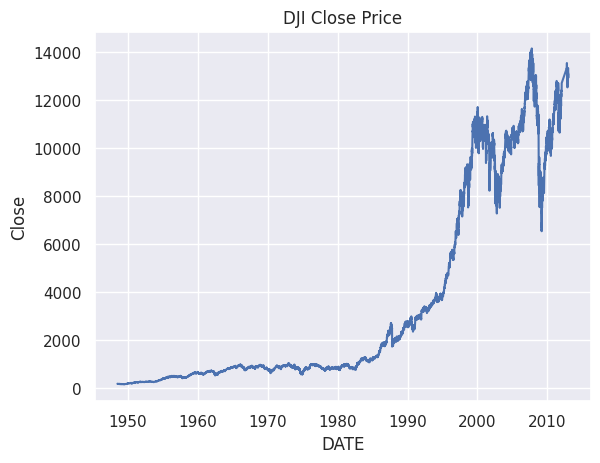

In [ ]:
_ = sns.lineplot(data=df.Close).set_title('DJI Close Price')

The plot shows evident non-stationarity in closing prices, with both mean and variance changing over time. Let's tackle the variance aspect first.

If you squint hard enough, the closing price time series appears similar to an exponential series, with variance significantly higher towards the right of the plot than towards the left. In order to linearize an exponential series, we apply the natural logarithm:


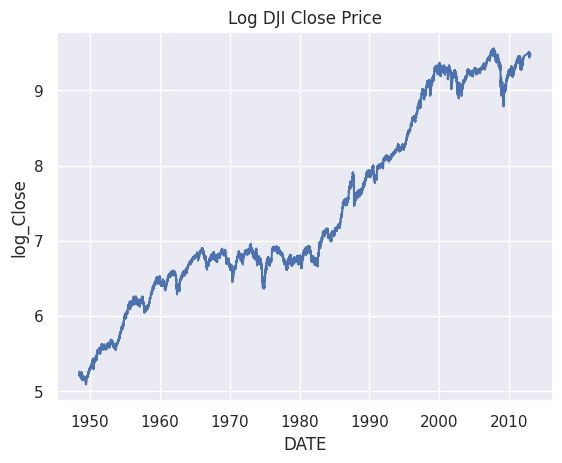

In [ ]:
df['log_Close'] = np.log(df.loc[:, 'Close'])
_ = sns.lineplot(data=df.log_Close).set_title('Log DJI Close Price')

The natural log-transformed time series appears far more linear, with a strong, deterministic trend. Taking the natural logarithm of price or economic time series is a common feature engineering step, particularly for variables exhibiting a constant or near-constant percentage growth rate. For example, consider a variable $y_t$ that grows at a rate of 7% per period indefinitely. Log transformation linearizes this series thanks to the following rules of logarithms:

$$
\text{For any variables }a\text{ and }b\text{:} \\\\
\begin{align}
ln(a \cdot b) &= ln(a) + ln(b) \\
ln(a^b) &= b \cdot ln(a)
\end{align}
$$

as follows:
$$
\begin{align}
y_t &= y_0 \cdot 1.07^t \\
ln(y_t) &= ln(y_0 \cdot 1.07^t) \\
ln(y_t) &= ln(y_0) + ln(1.07^t) \\
ln(y_t) &= ln(y_0) + t \cdot ln(1.07)
\end{align}
$$
where the last time series is a linear function of time.

With the `log_Closed` time series now more or less linear, the trend can be eliminated by first-differencing. However, caution is required as the `log_Closed` time series has missing data for certain time periods when the market was closed. The correct differencing approach is to subset the `log_Closed` time series to the available data, compute the difference from the previous observation, and then merge the result back with the original dataset:


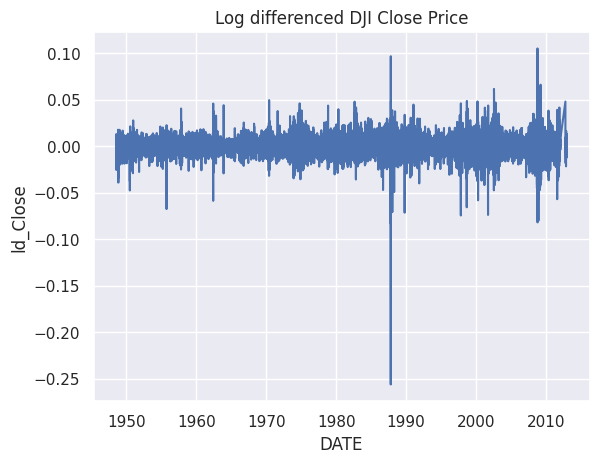

In [ ]:
log_Close = deepcopy(df.loc[:, 'log_Close'])
log_Close.dropna(inplace=True)
ld_Close = log_Close.diff()
df = df.merge(
    pd.DataFrame(ld_Close).rename({'log_Close':'ld_Close'},axis=1),
    how='left',
    left_index=True,
    right_index=True
)
_ = sns.lineplot(data=df.ld_Close).set_title('Log differenced DJI Close Price')

Using log-differences of a price series has additional benefits for financial analysis. For instance, consider the following table:

Time | Price | $log_e$(Price) | % change in Price (decimal format) | Log difference in price |
| :-: | :-: | :-: | :-: | :-: |
| 1 | 100 | 4.605 | - | - |
| 2 | 110 | 4.700 | 0.1 | 0.095 |
| 3 | 100 | 4.605 | -0.091 | -0.095 |

An asymmetry in percentage changes becomes apparent when considering a price that rises from \\\\$100 to \\$110 and then falls back from \\$110 to \\$100. The percentage change, in decimal format, is 0.1 for the increase but -0.091 for the decrease, even though the price has returned to its original value. In contrast, when examining log differences, the movement from \\$100 to \\$110 results in a log difference of 0.095, and the reverse movement from \\$110 to \\$100 yields a log difference of -0.095. This symmetry in log price movements allows us to track changes in price over time by summing log movements. The symmetry in log differences arises from the inherent properties of natural logarithms, including the following rule:

$$
\text{For any variables }a\text{ and }b\text{:} \\
\begin{align}
ln(a/b) &= ln(a) - ln(b)
\end{align}
$$

For two price movements in time series $x_t$:

$$
\begin{align}
ln(x_{t+2}/{x_t}) &= ln(x_{t+2}/{x_{t+1}} \cdot x_{t+1}/{x_{t}}) \\
&= ln(x_{t+2}) - ln({x_{t+1}}) + ln(x_{t+1}) - ln({x_t}) \\
&= ln(x_{t+2}) - ln({x_t})
\end{align}
$$

And, in general, for $N$ price movements, we have:

$$
\begin{align}
ln(x_{t+N}/{x_t}) &= ln(x_{t+N}/{x_{t+N-1}} \cdot x_{t+N-1}/{x_{t+N-2}} \cdot x_{t+N-2}/{x_{t+N-3}} \cdot \cdots \cdot x_{t+1}/{x_{t}}) \\
&= ln \bigg(\prod^{N}_{n=1} x_{t+n}/{x_{t+n-1}} \bigg) \\
&= \sum^{N}_{n=1} ln(x_{t+n}/{x_{t+n-1}}) \\
&= \sum^{N}_{n=1} (ln(x_{t+n}) - ln(x_{t+n-1})) \\
&= ln(x_{t+N}) - ln({x_t})
\end{align}
$$

Thus, when the price moves up to \\$110 and then back down to \\$100, the resulting change in log differences is 0.095 + (-0.095) = 0, reflecting the fact that the price has not actually changed across the two periods.

To sum up the discussion on log differences, a word about terminology. Because the magnitudes of log differences resemble those of percentage changes for relatively small changes in price, log differences are frequently called "log returns" or simply "returns" in the financial and economic literature.


To assess the stationarity of the log-differenced DJI prices, <a href="https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test">Augmented Dickey-Fuller (ADF)</a> and <a href="https://en.wikipedia.org/wiki/KPSS_test">Kwiatkowski–Phillips–Schmidt–Shin (KPSS)</a> tests can be conducted. For each of these tests, the following prints the <a href="https://en.wikipedia.org/wiki/P-value">p-value</a> of the test. The p-value of a test states the probability that the observed test result would occur through random chance alone, and is a useful in assessing whether to reject the null hypothesis in favor of the alternative.


In [ ]:
print('p-value of ADF test:')
print(adfuller(df.ld_Close.dropna())[1])
print('p-value of KPSS test:')
print(kpss(df.ld_Close.dropna())[1])

p-value of ADF test:
0.0
p-value of KPSS test:
0.1


The null hypothesis of the ADF test is that the time series has a unit root (in other words, that the time series is not stationary), and the alternative hypothesis is that the time series is stationary. As indicated by the extremely low p-value, which is estimated to be close to zero and is thus rounded to zero, there is evidence to reject the null hypothesis. We can therefore conclude that, according to the ADF test, the log-differenced closing price time series is stationary.

By contrast, the null hypothesis of the KPSS test is trend-stationarity, and the alternative is non-stationarity. The high p-value of the KPSS test, at 0.1 or greater (note that the p-values for the KPSS test are clipped at 0.1), does not provide sufficient evidence to reject the null hypothesis. Therefore, the ADF and KPSS tests are in conformity: they both confirm that the time series is stationary.

A question that often arises is what should be done with data where only one of the stationarity tests indicates a stationary series while the other one does not. Several combinations are possible here:

- Case 1: Both tests confirm non-stationarity - The series is non-stationary.
- Case 2: Both tests confirm stationarity - The series is stationary.
- Case 3: KPSS indicates stationarity, and ADF indicates non-stationarity - The series is trend-stationary. To achieve strict stationarity, the trend must be removed. Check the detrended series for stationarity.
- Case 4: KPSS indicates non-stationarity, and ADF indicates stationarity - The series is difference-stationary. To attain stationarity, differencing should be applied. Check the differenced series for stationarity.


One final check that could be done to ensure that the data is indeed stationary is to check for seasonality using a <a href="https://en.wikipedia.org/wiki/Periodogram">periodogram</a>. A periodogram is a diagram that is used to identify the dominant frequencies in a time series:


<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

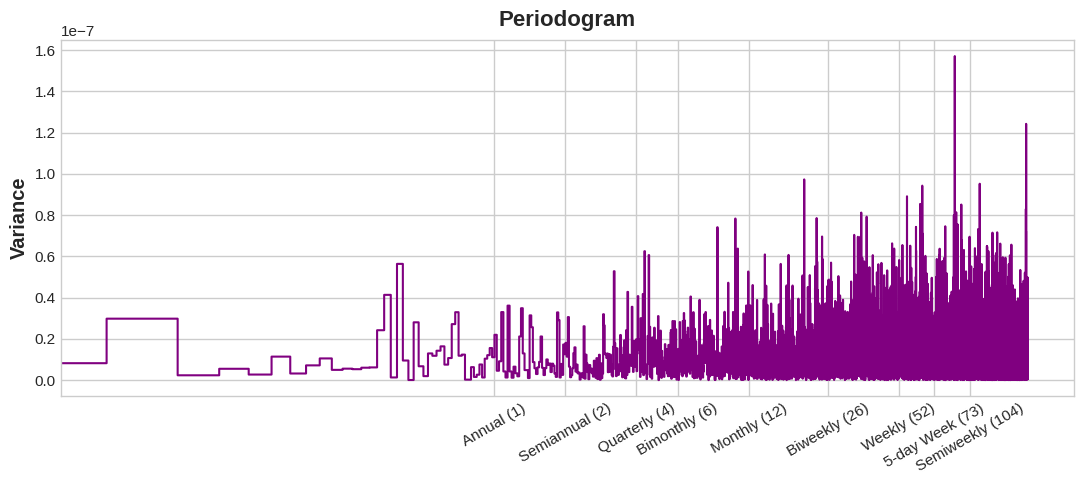

In [ ]:
def plot_periodogram(ts, detrend='linear', ax=None):
    fs = pd.Timedelta("365D6H") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 73, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "5-day Week (73)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)


plot_periodogram(df.loc[:, 'ld_Close'].dropna())

For completeness, one could also look at the periodogram of the undifferenced series:


<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

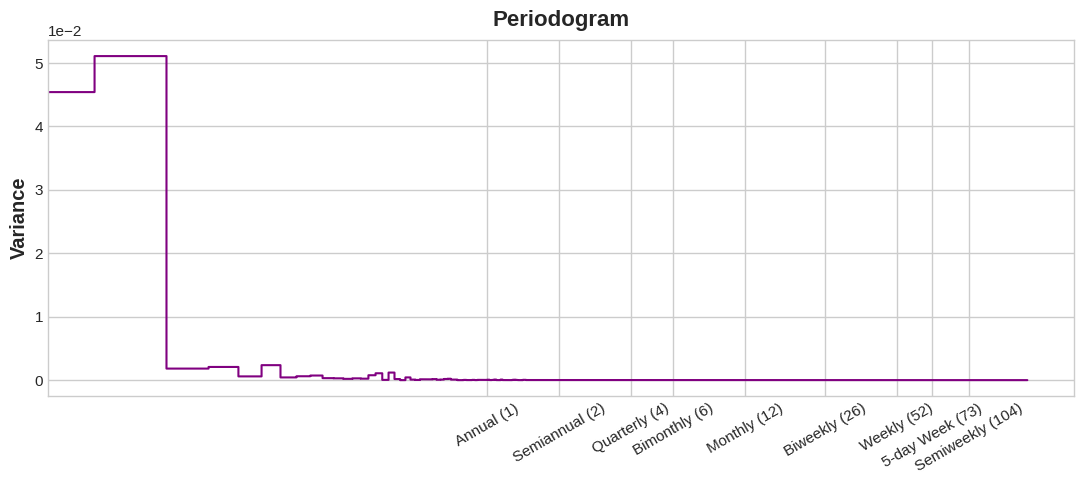

In [ ]:
plot_periodogram(df.loc[:, 'log_Close'].dropna())

The periodogram analysis reveals no significant peaks at frequencies where seasonality is typically expected. While there is a mild indication of seasonality at a 6-day cycle for the differenced series, it is not particularly prominent. For practical purposes, it can be assumed that the log returns of the DJI index are not strongly seasonal or cyclical. If there was a clear cyclical pattern, it would present an opportunity for investors to earn excess returns by following that cycle. However, such anomalies are quickly identified and replicated by other investors, leading to purchase and sale actions that eliminate the anomaly. Therefore, the DJI log returns are assumed to be devoid of seasonality and are considered stationary.


## Construct the features

In addition to ensuring the outcome variable is stationary, it is imperative to ensure that the features are stationary as well.


### Make the average temperature time series stationary

First, consider the plot of average temperatures:


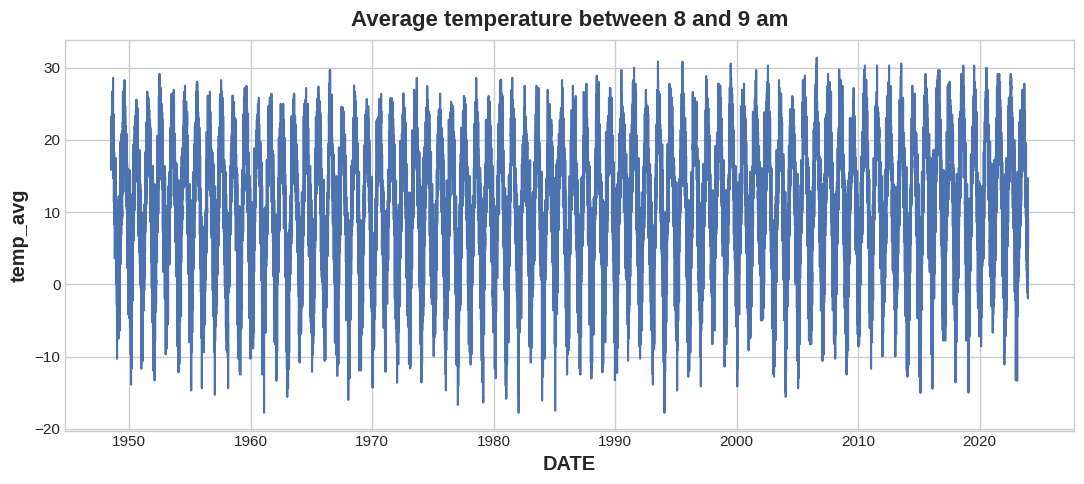

In [ ]:
_ = sns.lineplot(data=df['temp_avg']).set_title('Average temperature between 8 and 9 am')

This time series exhibits a very strong seasonal component: temperatures vary in a predictable way by season. We can confirm the presence of seasonality by analyzing the periodogram:


<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

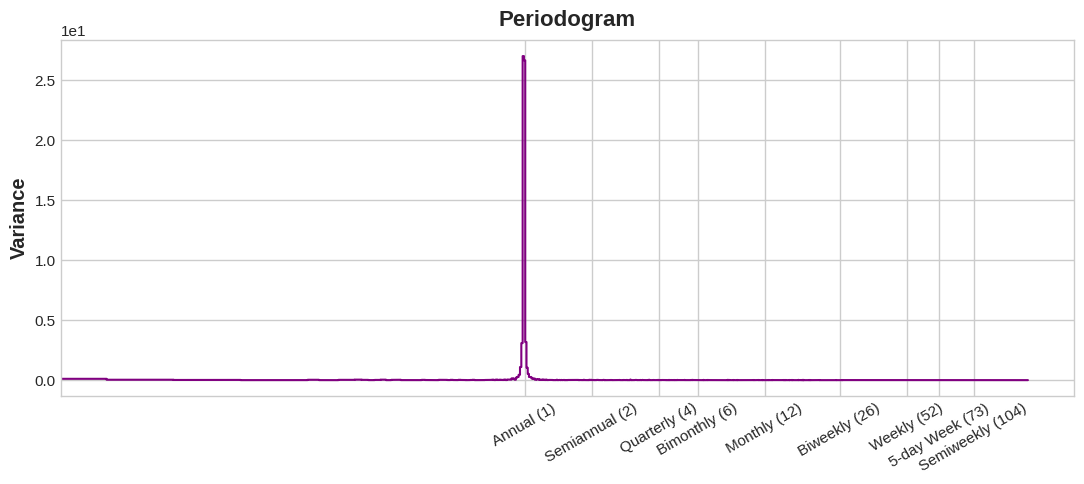

In [ ]:
plot_periodogram(df.loc[:, 'temp_avg'].dropna())

It is obvious that the time series exhibits strong seasonality at the annual frequency. The time series must be seasonally adjusted in order to produce a stationary series.

Several methods exist for seasonally adjusting a time series. Because we are interested in a prediction task, we will limit ourselves to methods that rely solely on past data and that can be readily applied to new data as it becomes available.

We will adopt a strategy of fitting a polynomial to the average temperatures for the initial years of the data and use that polynomial to estimate the seasonal effect moving forward. This approach offers some advantages over seasonal differencing, which relies on the difference between the current year's observation and the observation from the previous year. In particular, the polynomial fit is less influenced by unusually high or low readings from the previous year, as it considers a training window with data taken from multiple years, as well as from days that are not exactly 12 months before the current observation.

However, the drawback of using a polynomial fit is that a substantial number of years are required to generate the fit, and those years become unavailable for future analysis. In this case, I utilized 16 years, which provides a sufficiently large data sample for a robust fit, while also being a multiple of 4, which helps to account for leap years occurring every 4 years. The order of the polynomial fit could be 4 or 5, as these orders ought to be adequate to produce a curve resembling a sine wave. Feel free to experiment with the order in your own projects. In this analysis, I used a fourth-order polynomial:


In [ ]:
# Seasonally adjust average temp
y = df.loc[df.index < '1964-01-02', 'temp_avg']
X = [i % 365.25 for i in range(0, len(y.to_numpy()))]
X_full = [i % 365.25 for i in range(0, len(df.temp_avg.to_numpy()))]
degree = 4
coef = np.polyfit(X, y.to_numpy(), degree)
print('Coefficients: %s' % coef)
# create seasonal component
temp_sc_avg = list()
for i in range(len(X_full)):
    value = coef[-1]
    for d in range(degree):
        value += X_full[i]**(degree-d) * coef[d]
    temp_sc_avg.append(value)

df['temp_sc_avg'] = temp_sc_avg
df['temp_sa'] = df['temp_avg'] - df['temp_sc_avg']

Coefficients: [-2.27039916e-08  1.89119633e-05 -4.47566270e-03  2.22570025e-01
  1.91433822e+01]


Plot the periodogram of the seasonally adjusted temperature data:


<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

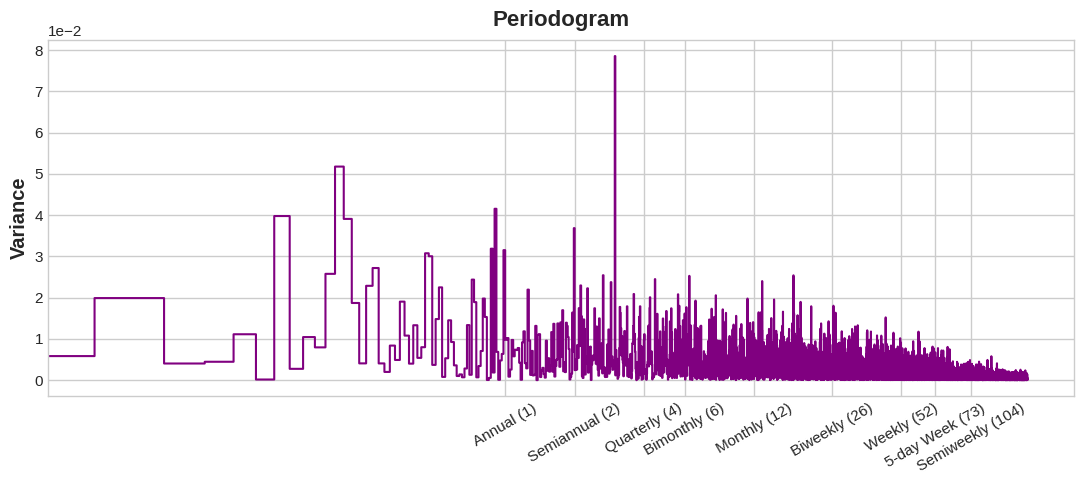

In [ ]:
plot_periodogram(df.loc[df.index >= '1964-01-02', 'temp_sa'].dropna())

The periodogram indicates that the seasonal adjustment successfully eliminated the seasonal component at the annual frequency.

Now, test the seasonally adjusted temperature data for stationarity:


In [ ]:
print('p-value of ADF test:')
print(adfuller(df.loc[df.index >= '1964-01-02', 'temp_sa'].dropna())[1])
print('p-value of KPSS test:')
print(kpss(df.loc[df.index >= '1964-01-02', 'temp_sa'].dropna())[1])

p-value of ADF test:
0.0
p-value of KPSS test:
0.01


According to the ADF test, the data exhibits stationarity. However, the KPSS test suggests non-stationarity. This discrepancy is surprising and suggests that temperatures in New York City follow a stochastic trend, meaning the temperature time series does not revert to its previous state after a shock. Notably, the stationarity tests did not indicate a deterministic trend in temperature (as would be the case if KPSS indicated stationarity but ADF did not). This implies that global warming is not a deterministic process but rather a result of various shocks leading to higher mean temperatures in locations such as New York City.

In order to make a time series with a stochastic trend stationary, we difference the series:


In [ ]:
df['temp_sa_d'] = df['temp_sa'].diff()
print('p-value of ADF test:')
print(adfuller(df.loc[df.index >= '1964-01-02', 'temp_sa_d'].dropna())[1])
print('p-value of KPSS test:')
print(kpss(df.loc[df.index >= '1964-01-02', 'temp_sa_d'].dropna())[1])

p-value of ADF test:
0.0
p-value of KPSS test:
0.1


### Make the average cloud cover time series stationary

Perform the following exercises to make the `cloud_cover_avg` series stationary:


Plot the periodogram for average cloud cover


Cloud cover periodogram:


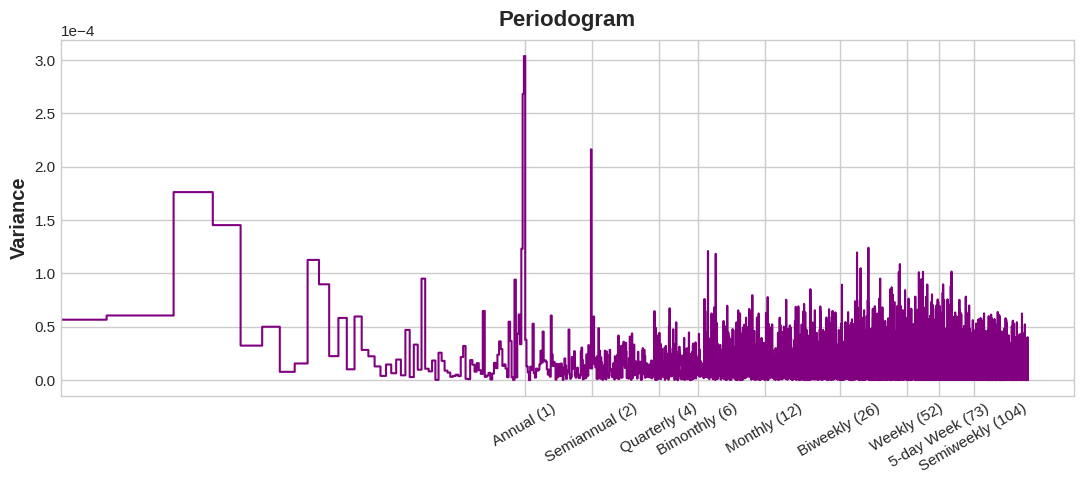

In [ ]:
print('Cloud cover periodogram:')
plot_periodogram(df.loc[:, 'cloud_cover_avg'].dropna())
plt.show()


Create the seasonal component to adjust cloud cover by filling in the missing code in the `for` loop below. Store the seasonal component in a variable called `value`.


In [ ]:
# Seasonally adjust average cloud_cover
y = df.loc[df.index < '1964-01-02', 'cloud_cover_avg']
X = [i % 365.25 for i in range(0, len(y.to_numpy()))]
X_full = [i % 365.25 for i in range(0, len(df.cloud_cover_avg.to_numpy()))]
degree = 4
coef = np.polyfit(X, y.to_numpy(), degree)
print('Coefficients: %s' % coef)
# create seasonal component
cloud_cover_sc_avg = list()
for i in range(len(X_full)):
    value = coef[-1]
    for d in range(degree):
        value = coef[-1]
        for d in range(degree):
            value += X_full[i]**(degree-d) * coef[d]
    cloud_cover_sc_avg.append(value)

df['cloud_cover_sc_avg'] = cloud_cover_sc_avg
df['cloud_cover_sa'] = df['cloud_cover_avg'] - df['cloud_cover_sc_avg']

# Check
if not np.isclose(df['cloud_cover_sa'].iloc[-3:].to_numpy(), np.array([0.47207492, 0.42967688, 0.42895152])).min():
    raise Exception('You did not complete this exercise correctly. Try again!')

Coefficients: [ 9.14705856e-11 -9.24871549e-08  2.91763216e-05 -2.91766022e-03
  5.51703112e-01]


---


The following code plots the periodogram for seasonally adjusted cloud cover


Periodogram for seasonally adjusted cloud cover:


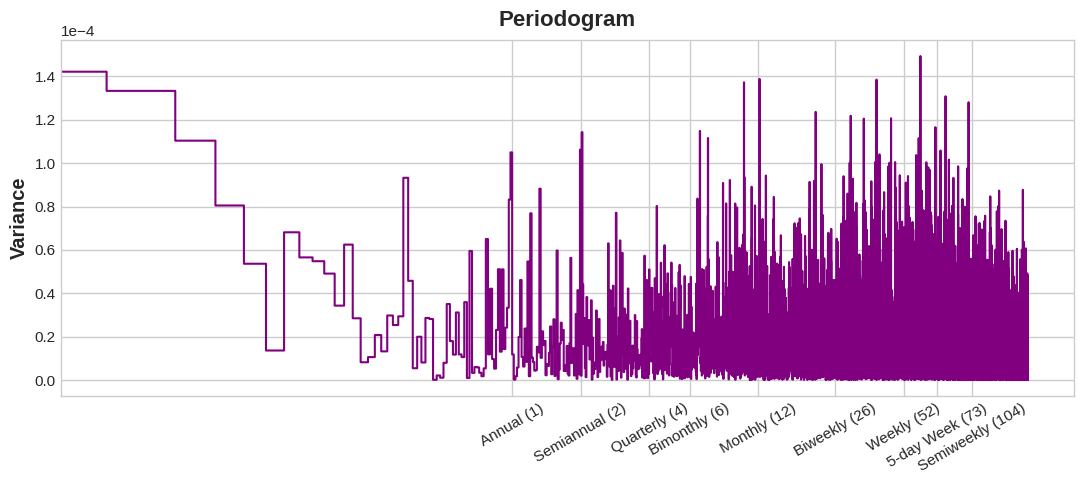

In [ ]:
print('Periodogram for seasonally adjusted cloud cover:')
plot_periodogram(df.loc[df.index >= '1964-01-02', 'cloud_cover_sa'].dropna())
plt.show()

Perform the ADF and KPSS tests on seasonally adjusted cloud cover for the period from January 2nd, 1964 onward. Extract just the p-value from the results to these tests. What conclusion can you reach on the basis of these tests? Is seasonally adjusted cloud cover stationary?


In [ ]:
print('Stationarity tests for seasonally adjusted cloud cover')
print('p-value of ADF test:')

print(adfuller(df.loc[df.index >= '1964-01-02', 'cloud_cover_sa'].dropna())[1])

print('p-value of KPSS test:')
print(kpss(df.loc[df.index >= '1964-01-02', 'cloud_cover_sa'].dropna())[1])

Stationarity tests for seasonally adjusted cloud cover
p-value of ADF test:
0.0
p-value of KPSS test:
0.01


Make the seasonally adjusted cloud cover series stationary by first differencing. Store the result in a column called `cloud_cover_sa_d`


In [ ]:
df['cloud_cover_sa_d'] = df['cloud_cover_sa'].diff()

# Check
if not np.isclose(df['cloud_cover_sa_d'].iloc[-3:].to_numpy(), np.array([-0.00073722, -0.04239804, -0.00072536])).min():
    raise Exception('You did not complete this exercise correctly. Try again!')

---


The following code employs the ADF and KPSS tests to verify that the first differenced seasonally adjusted cloud cover series is stationary:


In [ ]:
print('################################')
print('Stationarity tests for differenced seasonally adjusted cloud cover')
print('p-value of ADF test:')
print(adfuller(df.loc[df.index >= '1964-01-02', 'cloud_cover_sa_d'].dropna())[1])
print('p-value of KPSS test:')
print(kpss(df.loc[df.index >= '1964-01-02', 'cloud_cover_sa_d'].dropna())[1])

################################
Stationarity tests for differenced seasonally adjusted cloud cover
p-value of ADF test:
0.0
p-value of KPSS test:
0.1


The ADF and KPSS tests above indicate that differencing the seasonally adjusted cloud cover time series was sufficient to obtain a stationary series.


As a final step, we should now remove the first 16 years from the dataset because we used those years to fit the polynomials for seasonal adjustment:


In [ ]:
df = df.loc[df.index >= '1964-01-02']

# Time series train-test split and cross-validation

With non-time series data, as long as the data is not grouped, the train-test split can be made by randomly assigning a certain fraction of observations to the training set, with the rest of the observations assigned to the test set.

With time series data, this process is more complex. Because the observations occur in a particular order, typically the earlier observations are assigned to the training set, and latter observations are assigned to the test set. It is important to leave a gap between the two sets of at least the number of lagged variables included in the model so as to avoid data leakage between the train and test sets.

Cross-validation proceeds in a similar fashion. In the first fold, a pre-defined fraction of the earliest observations, say the first 18% of observations, are used to train the model; the next 1% of observations are left as a gap; and that model is then used to predict the next 18% of observations. Then, for the next fold, the model is trained on 36% of the earliest data, the next 1% is left as a gap, and the test set comprises the next 18%, and so on. Run the following code to generate a plot that illustrates this concept:


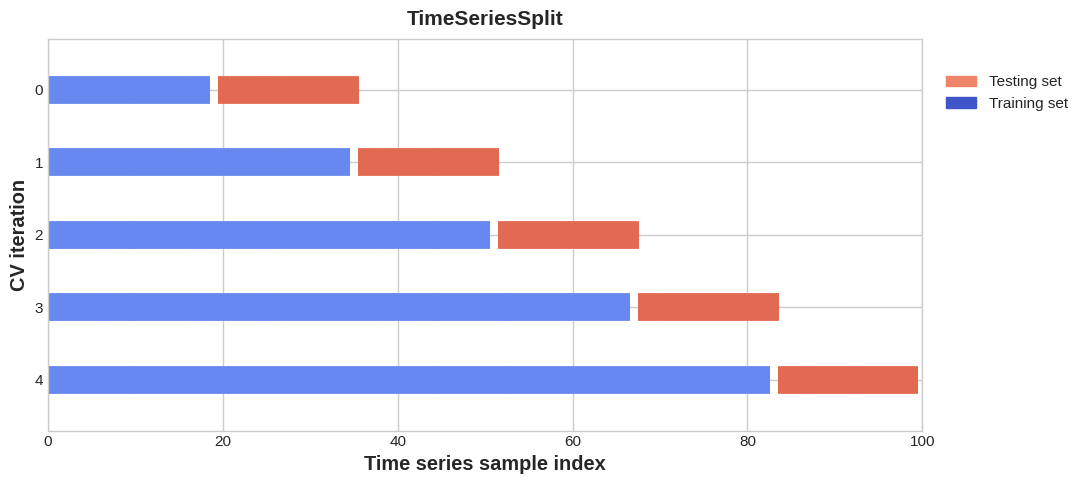

In [ ]:
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm


def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=20):
    """Create a sample plot for indices of a cross-validation object."""
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0
        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            s=50,
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )
    # Formatting
    yticklabels = list(range(n_splits))
    ax.set(
        yticks=np.arange(n_splits) + 0.5,
        yticklabels=yticklabels,
        xlabel="Time series sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 0.2, -0.2],
        xlim=[0, 100],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax


fig, ax = plt.subplots()
cv = TimeSeriesSplit(5, gap=1)
rng = np.random.RandomState(2024)
X = rng.randn(100, 10)
percentiles_classes = [0.33, 0.33, 0.34]
y = np.hstack(
    [[ii] * int(100 * perc) for ii, perc in enumerate(percentiles_classes)]
)
group_prior = rng.dirichlet([2] * 10)
groups = np.repeat(np.arange(10), rng.multinomial(100, group_prior))
plot_cv_indices(cv, X, y, groups, ax, 5)
ax.legend(
        [Patch(color=cmap_cv(0.8)), Patch(color=cmap_cv(0.02))],
        ["Testing set", "Training set"],
        loc=(1.02, 0.8),
)
# Make the legend fit
plt.tight_layout()
fig.subplots_adjust(right=0.7)

## Define the folds for cross-validation

We will proceed to partition the data into 10 train-test folds, following the pattern illustrated in the plot above. Additionally, we will implement a 15-day gap to prevent any data leakage between the train and test sets in each fold. (Note: If you anticipate utilizing more than 15 lags in your model, it is advisable to include a larger gap. However, for our purposes, 15 days will suffice):


In [ ]:
# Time series split
tscv = TimeSeriesSplit(n_splits=10, gap=15)
splits = list(tscv.split(df.ld_Close.dropna()))

# Construct and evaluate the prediction models using cross-validation

It is finally time to build some prediction models, and to assess their performance using cross-validation!

To evaluate the models' performance, we will employ the mean absolute error (MAE) metric. This choice is appropriate as the MAE provides insights into how much our mean prediction deviates from the true log return. Given that log returns have a natural interpretation—particularly for small percentage changes where the log return is approximately equivalent in magnitude to the percentage change—the MAE is a suitable metric. For instance, if the MAE is 0.005, it implies that, on average, our prediction deviates by roughly half a percentage point from the true daily percentage return.


# Linear regression


## Predict using the mean from the training period

The most basic model that could be conceived is one that predicts the daily log return using the mean from the training period. Such a prediction can be made by regressing log returns on a vector of ones. The following trains 10 such models, one for every fold in our cross-validation. Each of these models is used to make one-step-ahead predictions for the observations in their fold's test set. A mean absolute error is then calculated using the predictions from all 10 folds:


In [ ]:
trues_raw = []
preds_raw = []
results_ols_m = []
for i in tqdm.tqdm_notebook(range(len(splits))):
    mod = sm.OLS(
        df.ld_Close.dropna().to_numpy()[splits[i][0]],
        sm.add_constant(
            df.ld_Close.dropna().to_numpy()[splits[i][0]]
        )[:, [0]]
    )
    res = mod.fit(disp=False)
    pred = res.predict(
        sm.add_constant(
            df.ld_Close.dropna().to_numpy()[splits[i][1]]
        )[:, [0]]
    )
    preds_raw.append(pred)
    trues_raw.append(df['ld_Close'].dropna().to_numpy()[splits[i][1]])
    results_ols_m.append(res)

trues = np.concatenate(trues_raw)
preds = np.concatenate(preds_raw)
reg_mean_absolute_error = mean_absolute_error(trues, preds)

linreg_mean_mae = []
for i in range(len(trues_raw)):
    linreg_mean_mae.append(mean_absolute_error(trues_raw[i], preds_raw[i]))

print('MAE, regress on constant alone: ' + str(reg_mean_absolute_error))
del mod, res, pred

  0%|          | 0/10 [00:00<?, ?it/s]

MAE, regress on constant alone: 0.007391160254661744


The results show that across all predictions made using the 10 folds, the mean absolute error (MAE) was 0.007391. This corresponds to a roughly 0.7391 percentage point difference between the true daily return and the predicted daily return, on average.


### Predict using a linear regression with temperature and cloud cover as inputs

Perform the following exercise to predict daily log returns by regressing log returns on a constant, average temperature, and cloud cover in NYC between 8 and 9 am:


Fill in the missing code in order to fit the model. Store the fitted model in a variable called `res`


In [ ]:
trues_raw = []
preds_raw = []
results_ols_tcc = []
for i in tqdm.tqdm_notebook(range(len(splits))):
    mod = sm.OLS(
        df.ld_Close.dropna().to_numpy()[splits[i][0]],
        sm.add_constant(
            df[['ld_Close', 'temp_sa_d', 'cloud_cover_sa_d']].dropna().loc[
                :, ['temp_sa_d', 'cloud_cover_sa_d']
            ].to_numpy()[splits[i][0]]
        )
    )
    res = mod.fit(disp=False)
    pred = res.predict(
        sm.add_constant(
            df[['ld_Close', 'temp_sa_d', 'cloud_cover_sa_d']].dropna().loc[
                :, ['temp_sa_d', 'cloud_cover_sa_d']
            ].to_numpy()[splits[i][1]]
        )
    )
    preds_raw.append(pred)
    trues_raw.append(df['ld_Close'].dropna().to_numpy()[splits[i][1]])
    results_ols_tcc.append(res)

trues = np.concatenate(trues_raw)
preds = np.concatenate(preds_raw)
reg_mean_absolute_error = mean_absolute_error(trues, preds)

linreg_weather_mae = []
for i in range(len(trues_raw)):
    linreg_weather_mae.append(mean_absolute_error(trues_raw[i], preds_raw[i]))

print('MAE, regress on weather variables: ' + str(reg_mean_absolute_error))
del mod, res, pred

  0%|          | 0/10 [00:00<?, ?it/s]

MAE, regress on weather variables: 0.0073890777718353074


---


As observed above, a marginal improvement in prediction is achieved by incorporating the weather variables.

As part of the diagnostic process, examining the p-values associated with the coefficients in the linear regression could provide valuable insights. To carry out this analysis, we can focus on the regression from the last fold, as it contains the most training data:


In [ ]:
results_ols_tcc[-1].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     3.566
Date:                Mon, 19 Aug 2024   Prob (F-statistic):             0.0283
Time:                        08:37:29   Log-Likelihood:                 35483.
No. Observations:               11023   AIC:                        -7.096e+04
Df Residuals:                   11020   BIC:                        -7.094e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003   9.22e-05      2.868      0.004    8.37e-05       0.000
x1          1.218e-05   2.57e-05      0.474      0.636   -3.82e-05    6.26e-05
x2            -0.0005      0.000     -2.625      0.009      -0.001      -0.000
==============================================================================
Omnibus:                     6420.919   Durbin-Watson:                   1.878
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1139067.254
Skew:                          -1.738   Prob(JB):                         0.00
Kurtosis:                      52.679   Cond. No.                         7.67
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The coefficient on x1, representing the seasonally adjusted and differenced average temperature, has a p-value of 0.636. By contrast, the second coefficient, the one on seasonally adjusted and differenced average cloud cover, has a p-value of 0.009. This suggests that cloud cover is linearly related to log returns for the DJI index at the 0.01 significance level.


### Predict using a linear regression with cloud cover as an input

Now, let's simplify the regression further by regressing log returns on a constant and cloud cover, excluding the temperature because the coefficient on temperature was not significant:


Fill in the missing code to define a linear regression model that predicts log returns using a constant and stationary cloud cover. Store the model in the `mod` variable


In [ ]:
trues_raw = []
preds_raw = []
results_ols_cc = []
for i in tqdm.tqdm_notebook(range(len(splits))):

    mod = sm.OLS(
        df.ld_Close.dropna().to_numpy()[splits[i][0]],
        sm.add_constant(
            df[['ld_Close', 'cloud_cover_sa_d']].dropna().loc[
                :, ['cloud_cover_sa_d']
            ].to_numpy()[splits[i][0]]
        )
    )
    res = mod.fit(disp=False)

    pred = res.predict(
        sm.add_constant(
            df[['ld_Close', 'cloud_cover_sa_d']].dropna().loc[
                :, ['cloud_cover_sa_d']
            ].to_numpy()[splits[i][1]]
        )
    )
    preds_raw.append(pred)
    trues_raw.append(df['ld_Close'].dropna().to_numpy()[splits[i][1]])
    results_ols_cc.append(res)

trues = np.concatenate(trues_raw)
preds = np.concatenate(preds_raw)
reg_mean_absolute_error = mean_absolute_error(trues, preds)

linreg_cc_mae = []
for i in range(len(trues_raw)):
    linreg_cc_mae.append(mean_absolute_error(trues_raw[i], preds_raw[i]))

print('MAE, regress on weather variables: ' + str(reg_mean_absolute_error))
del mod, res, pred

  0%|          | 0/10 [00:00<?, ?it/s]

MAE, regress on weather variables: 0.0073883918328644434


---


Once more, the mean absolute error exhibits a slight improvement. Let's delve into the details of the regression from the last fold:


In [ ]:
results_ols_cc[-1].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     6.908
Date:                Mon, 19 Aug 2024   Prob (F-statistic):            0.00859
Time:                        08:37:30   Log-Likelihood:                 35483.
No. Observations:               11023   AIC:                        -7.096e+04
Df Residuals:                   11021   BIC:                        -7.095e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003   9.22e-05      2.870      0.004    8.39e-05       0.000
x1            -0.0005      0.000     -2.628      0.009      -0.001      -0.000
==============================================================================
Omnibus:                     6420.919   Durbin-Watson:                   1.878
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1139119.829
Skew:                          -1.738   Prob(JB):                         0.00
Kurtosis:                      52.680   Cond. No.                         1.86
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Once again, cloud cover is found to be statistically significant at the 0.01 significance level. With this result, we can confidently assert that there is a linear relationship between cloud cover in New York City and the log returns of the DJI index.

Beyond this, we can make a more profound assertion. While correlation does not necessarily imply causation, and determining the direction of causation can be challenging, in this instance, we can rely on both reason and our domain knowledge of weather and stock markets in order to make a causal argument. Given that it is more plausible for weather conditions to drive stock market changes than the other way around (imagining a world where stock movements dictate the pre-open cloudiness would be highly unusual), we can claim that cloud cover in New York City <b><i>causes</i></b> some of the variation in the log returns of the DJI index. This is a significant and meaningful finding.

However, despite this impactful discovery, the regression results offer a sobering insight: the R-squared value, representing the proportion of the variation in log returns predicted by cloud cover in New York City, is exceedingly small, equal to 0.001 or less. The following code obtains the exact value of R-squared, or more precisely, the adjusted R-squared, a corrected version of R-squared that accounts for the number of predictors:


In [ ]:
results_ols_cc[-1].rsquared_adj

0.0005356987940902114

There you have it. Cloud cover in New York City explains just 0.054% of the variation in the log returns of the Dow Jones Industrial Average. While statistically significant, the economic significance of this finding is limited due to cloud cover's minor impact on the DJI.

On the other hand, would it have been reasonable to expect a larger effect from just one, easily observable variable? Certainly, for an exceedingly intricate system such as the stock market, where millions of individuals make decisions in their own best interests based on an immense amount of information, the surprising aspect lies in the fact that an easily observable variable like cloud cover has any statistical effect at all. It is just one of many variables moving the market, and its significance in moving that market is accordingly rather small.

As a final sanity check one should consider the sign on the coefficient of the variable of interest. In this particular case, the coefficient is negative. A negative coefficient implies that greater cloud cover is associated with lower DJI log returns. This is exactly what one would expect: an easy hypothesis, not tested in this guided project, is that an unseasonably large amount of cloud cover causes more gloom amongst traders and investors, causing them to sell more and buy less than they otherwise would on a nice day.

Even though cloud cover is identified as a causal factor for DJI log returns, the question remains whether or not cloud cover could be used to improve DJI log return predictions. If forecasts are made using linear regression, the above cross-validation suggests that the inclusion of cloud cover improves predictions ever so slightly over baseline predictions made by mean returns. It seems that, at least within the realm of linear regression, incorporating cloud cover could lead to slightly improved predictions.


## The ARMAX model

The aforementioned observation is indeed noteworthy, but its impact on our prediction accuracy, as measured by MAE, is not substantial. Let's investigate whether the inclusion of cloud cover proves beneficial in enhancing the prediction of the DJI within a more intricate model than a simple linear regression. In the upcoming analysis, we will construct an <a href="https://en.wikipedia.org/wiki/Autoregressive_moving-average_model#Autoregressive%E2%80%93moving-average_model_with_exogenous_inputs_model_(ARMAX_model)">ARMAX</a> model.

### An introduction to ARMAX models
ARMAX is a subset of the renowned <a href="https://www.statsmodels.org/devel/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html">SARIMAX</a> model, which stands for Seasonal AutoRegressive Integrated Moving Average with eXogenous variables. Through SARIMAX, ARMAX is directly related to the more known <a href="https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average">ARIMA</a> model: the ARMAX model is a subset of the SARIMAX model that does not use the seasonal or integrated components, while the ARIMA model is a subset of SARIMAX that does not use the seasonal and exogenous components. In order to understand the ARMAX model, it is best to start with an understanding of an autoregressive model of order $p$, the AR($p$) model, which predicts the current value of an outcome variable using $p$ lagged observations:

$$
\begin{align}
y_t &= \theta_0 + \sum_{i=1}^p \theta_i y_{t-i} + \epsilon_t
\end{align}
$$

where $\theta_0$ is a constant, $p$ is the number of lags, $\epsilon_t$ is the noise at time $t$, and $\theta_i$ is the coefficient on lag $i$.

This equation can be made concise using the lag operatior, $L$:

$$
\begin{align}
L^ny_t &= y_{t-n}
\end{align}
$$

If we denote $\Theta(L)^p$ to be a $p$ order polynomial function of the lag operator $L$, then the autoregressive model can be written as

$$
\begin{align}
y_t &= \Theta(L)^p y_{t} + \epsilon_t
\end{align}
$$

By contrast, a moving average (MA) model of order $q$ predicts the outcome variable using lagged prediction errors $\epsilon$:

$$
\begin{align}
y_t &= \Phi(L)^q \epsilon_{t} + \epsilon_t
\end{align}
$$

Putting these models together yields the ARMA($p$,$q$) model:

$$
\begin{align}
y_t &= \Theta(L)^p y_{t} + \Phi(L)^q \epsilon_{t} + \epsilon_t
\end{align}
$$

In order to convert to an ARMAX model, the $n$ exogenous variables enter the model additively:

$$
\begin{align}
y_t &= \Theta(L)^p y_{t} + \Phi(L)^q \epsilon_{t} + \sum_{i=1}^n \beta_i x^i_t +  \epsilon_t
\end{align}
$$

Thus, an ARMAX model differs from linear regression by adding lagged terms for the outcome variable and moving average terms that depend on the prediction error. Because of the dependence on the previous prediction error, this model cannot be solved using <a href="https://en.wikipedia.org/wiki/Ordinary_least_squares">ordinary least squares (OLS)</a>; instead, the <a href="https://en.wikipedia.org/wiki/Maximum_likelihood_estimation">maximum likelihood estimation (MLE)</a> method is typically used.

### Find optimal lag orders

Before continuing to construct an ARMA or ARMAX model, we must find optimal autogregressive and moving average orders.


Ideally, for a prediction task, one would employ cross-validation, testing various combinations of autoregressive (AR) and moving average (MA) lag orders and comparing the prediction accuracy using metrics like Mean Absolute Error (MAE). However, due to the time-consuming nature of fitting SARIMAX models and their derivatives using Maximum Likelihood Estimation (MLE), we'll opt for a quicker approach. We'll use the classical method of selecting lag orders, leveraging the <a href="https://en.wikipedia.org/wiki/Akaike_information_criterion">Akaike Information Criterion (AIC)</a> and the <a href="https://en.wikipedia.org/wiki/Bayesian_information_criterion">Bayesian Information Criterion (BIC)</a>. These criteria serve as estimators for prediction error and the relative quality of statistical models for a given dataset. The goal is to identify lag orders that minimize both AIC and BIC. If the lag orders minimizing AIC and BIC differ, the researcher can choose either order based on how parsimonious the model should be, with BIC typically favoring more parsimonious models than AIC.

As we're about to observe, this approach of selecting lag orders may not be optimal for a prediction task, despite the widespread use of information criteria for lag selection in ARIMA-type models. To expedite the process, we will execute the lag order selection code below for a limited range of autoregressive and moving average orders. Additionally, we will apply the code solely to the last fold, as it encompasses the largest volume of training data.


In [ ]:
# ARMA lag order selection using just one fold.
# This code may run for a minute or two.
# Feel free to grab a coffee before continuing!

min_ar_ma = [2,6] # Minimum (p, q)
max_ar_ma = [4,8] # Maximum (p, q)

# Note: according to the AIC criteria, identical AR and MA lags are found if
#       the maximum and minimum bounds are:
#min_ar_ma = [1,1] # Minimum (p, q)
#max_ar_ma = [8,8] # Maximum (p, q)


aic_pd = pd.DataFrame(
    np.empty((max_ar_ma[0]+1-min_ar_ma[0],
              max_ar_ma[1]+1-min_ar_ma[1]),
             dtype=float),
    index=list(range(max_ar_ma[0]+1-min_ar_ma[0])),
    columns=list(range(max_ar_ma[1]+1-min_ar_ma[1]))
)

bic_pd = pd.DataFrame(
    np.empty((max_ar_ma[0]+1-min_ar_ma[0],
              max_ar_ma[1]+1-min_ar_ma[1]),
             dtype=float),
    index=list(range(max_ar_ma[0]+1-min_ar_ma[0])),
    columns=list(range(max_ar_ma[1]+1-min_ar_ma[1]))
)

for p in tqdm.tqdm_notebook(range(
        min_ar_ma[0], max_ar_ma[0]+1), position=1, desc='p'):
    for q in range(min_ar_ma[1], max_ar_ma[1]+1):
        if p == 0 and q == 0:
            aic_pd.loc[p, q] = np.nan
            bic_pd.loc[p, q] = np.nan
            continue
        # Estimate the model with no missing datapoints
        mod = sm.tsa.statespace.SARIMAX(
            df['ld_Close'].dropna().iloc[splits[-1][0]],
            order=(p, 0, q),
            trend='c',
            enforce_invertibility=False
        )
        try:
            res = mod.fit(disp=False)
            aic_pd.loc[p, q] = res.aic
            bic_pd.loc[p, q] = res.bic
        except:
            aic_pd.loc[p, q] = np.nan
            bic_pd.loc[p, q] = np.nan

print('AIC: optimal AR order: ' +
      str(aic_pd.min(axis=1).idxmin()) +
      ', optimal MA order: ' +
      str(aic_pd.min().idxmin()))
print('BIC: optimal AR order: ' +
      str(bic_pd.min(axis=1).idxmin()) +
      ', optimal MA order: ' +
      str(bic_pd.min().idxmin()))


p:   0%|          | 0/3 [00:00<?, ?it/s]

AIC: optimal AR order: 2, optimal MA order: 7
BIC: optimal AR order: 2, optimal MA order: 7


In this scenario, both the AIC and BIC criteria agree on the optimal number of lags to be selected. It's important to note that even if the order bounds for $p$ and $q$ were expanded to a range between 1 and 8, as opposed to the more restrictive bounds chosen for efficiency purposes, the AIC criterion would have still recommended the same lag orders. Consequently, the proposed 2 autoregressive (AR) orders and 7 moving average (MA) orders are considered reasonable parameter values.


### Predict using the ARMA model

The following code trains and evaluates an ARMA model that depends only on historical DJI prices.


In [ ]:
trues = []
preds = []
results = []
for i in tqdm.tqdm_notebook(range(len(splits))):
    mod = sm.tsa.statespace.SARIMAX(
        df['ld_Close'].dropna().to_numpy()[splits[i][0]],
        order=(2, 0, 7),
        trend='c',
        enforce_invertibility=False
    )
    res = mod.fit(disp=False)
    pred = res.predict(
        data=df['ld_Close'].dropna().to_numpy(),
        start=splits[i][1][0],
        end=splits[i][1][-1]
    )
    preds.append(pred)
    trues.append(df['ld_Close'].dropna().to_numpy()[splits[i][1]])
    results.append(res)

trues = np.concatenate(trues)
preds = np.concatenate(preds)

arma_absolute_error = mean_absolute_error(trues, preds)
print('ARMA(2,7) MAE: ' + str(arma_absolute_error))

  0%|          | 0/10 [00:00<?, ?it/s]

ARMA(2,7) MAE: 0.007391203331046744


In this instance, we observe a surprising outcome: the ARMA(2,7) model performs worse than a linear regression model with a constant!

This result emphasizes the idea that employing a more complex model for a challenging prediction task doesn't guarantee improved predictions. Specifically, in this case, it's clear that adding 2 autoregressive lags and 7 moving average lags for the error term didn't enhance the model's predictive capabilities. While experimenting with different lag orders might produce varying results, the crucial lesson is that simply introducing more variables or opting for a more intricate model doesn't automatically result in superior performance.


### Predict using the ARMAX model with temperature and cloud cover as exogenous inputs

The following code fits an ARMAX(2,7) model with temperature and cloud cover as exogenous variables:


In [ ]:
trues = []
preds = []
results = []
for i in tqdm.tqdm_notebook(range(len(splits))):
    mod = sm.tsa.statespace.SARIMAX(
        df['ld_Close'].dropna().to_numpy()[splits[i][0]],
        order=(2, 0, 7),
        trend='c',
        enforce_invertibility=False,
        exog=df[['temp_sa_d', 'cloud_cover_sa_d', 'ld_Close']].dropna().loc[
            :, ['temp_sa_d', 'cloud_cover_sa_d']
        ].to_numpy()[splits[i][0]]
    )
    res = mod.fit(disp=False)
    pred = res.predict(
        data=df['ld_Close'].dropna().to_numpy(),
        start=splits[i][1][0],
        end=splits[i][1][-1],
        exog=df[['cloud_cover_sa_d', 'temp_sa_d', 'ld_Close']].dropna().loc[
            :, ['temp_sa_d', 'cloud_cover_sa_d']
        ].to_numpy()[splits[i][1][0]-16:splits[i][1][-1]]
    )
    preds.append(pred)
    trues.append(df['ld_Close'].dropna().to_numpy()[splits[i][1]])
    results.append(res)

trues = np.concatenate(trues)
preds = np.concatenate(preds)

armax_weather_absolute_error = mean_absolute_error(trues, preds)
print('ARMAX(2,7) with weather variables MAE: ' +
      str(armax_weather_absolute_error))

  0%|          | 0/10 [00:00<?, ?it/s]

ARMAX(2,7) with weather variables MAE: 0.007393388004059298


Once more, we encounter an unexpected discovery: integrating weather data into the ARMA model led to a deterioration in model performance!

The rationale is clear-cut. The incorporation of autoregressive and moving average terms obligated the model to train on these terms, despite their collective lack of predictive value. As a result, the model exhibited poorer performance, even with the addition of cloud cover&mdash;a variable that could marginally improve DJI index predictions.

Complete the following exercise delve into the ARMAX model summary for the last fold:


Print the model summary for the last fold


In [ ]:
results[-1].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                11023
Model:               SARIMAX(2, 0, 7)   Log Likelihood               35514.792
Date:                Mon, 19 Aug 2024   AIC                         -71003.584
Time:                        08:52:54   BIC                         -70908.583
Sample:                             0   HQIC                        -70971.582
                              - 11023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002      0.000      1.395      0.163   -9.54e-05       0.001
x1          1.305e-05    2.6e-05      0.501      0.616    -3.8e-05    6.41e-05
x2            -0.0005      0.000     -2.664      0.008      -0.001      -0.000
ar.L1         -0.3685      0.400     -0.921      0.357      -1.152       0.415
ar.L2          0.4558      0.317      1.437      0.151      -0.166       1.077
ma.L1          0.4323      0.400      1.081      0.279      -0.351       1.216
ma.L2         -0.4656      0.318     -1.464      0.143      -1.089       0.158
ma.L3         -0.0495      0.024     -2.024      0.043      -0.097      -0.002
ma.L4         -0.0007      0.014     -0.050      0.960      -0.027       0.026
ma.L5          0.0017      0.009      0.198      0.843      -0.015       0.019
ma.L6         -0.0068      0.008     -0.859      0.390      -0.022       0.009
ma.L7         -0.0162      0.007     -2.358      0.018      -0.030      -0.003
sigma2      9.298e-05   3.53e-07    263.176      0.000    9.23e-05    9.37e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):           1098183.66
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               1.54   Skew:                            -1.74
Prob(H) (two-sided):                  0.00   Kurtosis:                        51.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

---


Once more, we note that the p-value linked with the cloud cover coefficient is below 0.01, signifying statistical significance. Conversely, the p-value for temperature is high, surpassing 0.1. Furthermore, the cloud cover coefficient is negative and comparable in magnitude to the one derived from linear regression. These results confirm the linear association between cloud cover and log returns, a connection that persists even in the presence of autoregressive and moving average terms. However, any potential enhancement in prediction performance by incorporating weather variables is overshadowed by the model misspecification.


### Predict using the ARMAX model with cloud cover as an exogenous input

Since temperature was not statistically significant, evaluate an ARMAX model with just the cloud cover as an external variable by completing the following exercise:


Evaluate an ARMAX(2,7) model with just the cloud cover as an external variable by replacing the `# REPLACE WITH YOUR CODE` placeholder with the correct model order


In [ ]:
trues = []
preds = []
results = []
for i in tqdm.tqdm_notebook(range(len(splits))):
    mod = sm.tsa.statespace.SARIMAX(
        df[['cloud_cover_sa_d',
            'ld_Close']].dropna().ld_Close.to_numpy()[splits[i][0]],
        order=(2,0,7), # REPLACE WITH YOUR CODE,
        trend='c',
        enforce_invertibility=False,
        exog=df[['cloud_cover_sa_d', 'ld_Close']].dropna().loc[
            :, ['cloud_cover_sa_d']
        ].to_numpy()[splits[i][0]]
    )
    res = mod.fit(disp=False)
    pred = res.predict(
        data=df[['cloud_cover_sa_d', 'ld_Close']].dropna().ld_Close.to_numpy(),
        start=splits[i][1][0], end=splits[i][1][-1],
        exog=df[['cloud_cover_sa_d', 'ld_Close']].dropna().loc[
            :, ['cloud_cover_sa_d']
        ].to_numpy()[splits[i][1][0]-16:splits[i][1][-1]]
    )
    preds.append(pred)
    trues.append(
        df[['cloud_cover_sa_d', 'ld_Close']].dropna().ld_Close.to_numpy()[
            splits[i][1]
        ]
    )
    results.append(res)

trues = np.concatenate(trues)
preds = np.concatenate(preds)

armax_cc_absolute_error = mean_absolute_error(trues, preds)
print('ARMAX(2,7) with weather variables MAE: ' +
      str(armax_cc_absolute_error))
del mod, res, pred

  0%|          | 0/10 [00:00<?, ?it/s]

ARMAX(2,7) with weather variables MAE: 0.007392630045196354


---


The aforementioned outcome validates our suspicions: when model misspecification is present, the contribution of cloud cover in NYC to prediction improvement is constrained. Despite a marginal decrease in Mean Absolute Error (MAE) compared to the ARMAX model that incorporated both weather variables, the performance of the ARMAX model with cloud cover still falls short of the linear regression model with cloud cover.

For a comprehensive understanding, let's examine the model summary for the last fold:


In [ ]:
results[-1].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                11023
Model:               SARIMAX(2, 0, 7)   Log Likelihood               35516.947
Date:                Mon, 19 Aug 2024   AIC                         -71009.894
Time:                        08:56:41   BIC                         -70922.202
Sample:                             0   HQIC                        -70980.354
                              - 11023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002      0.000      1.488      0.137    -7.5e-05       0.001
x1            -0.0004      0.000     -2.606      0.009      -0.001      -0.000
ar.L1         -0.3695      0.248     -1.492      0.136      -0.855       0.116
ar.L2          0.4575      0.229      1.995      0.046       0.008       0.907
ma.L1          0.4319      0.247      1.747      0.081      -0.053       0.916
ma.L2         -0.4653      0.243     -1.916      0.055      -0.941       0.011
ma.L3         -0.0514      0.009     -5.583      0.000      -0.069      -0.033
ma.L4          0.0012      0.013      0.099      0.921      -0.023       0.026
ma.L5         -0.0003      0.008     -0.043      0.966      -0.016       0.016
ma.L6         -0.0043      0.008     -0.564      0.573      -0.019       0.011
ma.L7         -0.0189      0.006     -2.951      0.003      -0.031      -0.006
sigma2      9.297e-05   3.55e-07    261.613      0.000    9.23e-05    9.37e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):           1116500.26
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               1.54   Skew:                            -1.75
Prob(H) (two-sided):                  0.00   Kurtosis:                        52.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""


Once again, the p-value associated with the cloud cover coefficient stands at a very low 0.009, aligning with our expectations, and the coefficient itself carries a negative sign.

This analysis of the ARMAX model yields two crucial lessons. Firstly, in any prediction project, careful consideration of feature selection and hyperparameter tuning is essential, and irrelevant features should be eliminated if identified. Secondly, opting for a more complex model doesn't automatically translate to superior predictions. Simple models, like linear regression, often excel when faced with challenging prediction tasks where the association between features and the outcome variable is not particularly strong.

While it's conceivable that an ARMAX-type model might perform better with the correct number of AR and MA lags, the current analysis doesn't strongly advocate for choosing an ARMAX model over the simpler linear regression model. The evidence gathered so far suggests that substantial improvements beyond the predictions made by linear regression are unlikely. Nonetheless, from a statistical standpoint, the ARMAX model summaries support the conclusion that cloud cover maintains a linear association with log returns, even in the presence of autoregressive and moving average terms.


## Random forest

In this section, we will fit an entirely different type of model to the data. Instead of relying on classical methods, we will now fit a <a href="https://en.wikipedia.org/wiki/Random_forest">random forest</a> model, a model that relies on <a href="https://en.wikipedia.org/wiki/Decision_tree_learning">decision trees</a>. In essence, decision trees resemble flow charts and split the data using cutoffs that maximize the separation of the data. A model based on decision trees may work particularly well on problems where certain cutoffs are of particular interest. For instance, if cloud cover being equal to or greater than 7/8 was associated with lower log returns, presumably because that is the threshold at which most traders begin to feel gloomy, then an algorithm that relies on decision trees should be able to pick that up with ease.

A common misconception about tree-based algorithms is that they cannot be used for time series analysis. This misunderstanding arises from the fact that tree-based algorithms are not proficient at extrapolation. For example, if you have an increasing series, such as the US GDP, that you aim to predict, tree-based models would only be capable of predicting the highest value encountered in training. Since time series train-test splits typically allocate later (larger) values to the test set, the decision tree-based model performs poorly as it cannot predict these future values effectively&mdash;it cannot make predictions beyond the range of what the model saw during training.

Furthermore, because tree-based models rely on making cutoffs, it is crucial that the features fed into these models are not trending. For instance, including US GDP as a feature in any tree-based model wouldn't make much sense: the cutoffs the trees would learn on previous GDP values would not hold much significance in testing, where GDP values are in a different range.

Consequently, decision-tree-based models can be used for time series analysis, provided that the features and the outcome variable are consistently within the same range throughout the entire dataset. While stationarity is a sufficient condition, it is not strictly necessary for tree-based algorithms. Instead, what is crucial is that the data is bounded, and a significant portion of the testing data is not outside the bounds of the data seen in training.

For our analysis, utilizing log-differenced DJI index prices as the outcome variables and seasonally adjusted and differenced cloud cover and temperature features is suitable, given their stationarity. Additionally, incorporating lags of the outcome variable as features is considered. While the optimal number of lags and other hyperparameter values could be determined through cross-validation, for simplicity, we will use 2 lags in this case. Furthermore, to expedite training time, we will set the max depth to just 2, though it is standard practice in real-world scenarios to find the optimal max depth through cross-validation.


### Predict using a random forest regressor with lagged observations as inputs

The following runs a random forest model on just two lags of log differenced DJI index prices:


In [ ]:
trues_rf = []
preds_rf = []
X_orig = df[['ld_Close']].dropna()
features = []
for i in range(1,3):
    features.append(
        df[['ld_Close']].dropna().shift(i).rename(
            {'ld_Close': 'ld_Close_'+str(i)}, axis=1
        )
    )
X = pd.concat(features + [X_orig], axis=1)
y = deepcopy(X_orig[['ld_Close']])
X.drop('ld_Close',axis=1,inplace=True)
for i in tqdm.tqdm_notebook(range(len(splits))):
    regr = RandomForestRegressor(criterion="absolute_error",
                                 n_estimators=10,
                                 max_depth=2,
                                 random_state=2024)
    train_idx = splits[i][0][2:]
    res = regr.fit(X.iloc[train_idx],y.iloc[train_idx])
    pred = regr.predict(X.iloc[splits[i][1]])
    preds_rf.append(pred)
    trues_rf.append(
        df[['ld_Close']].dropna().ld_Close.to_numpy()[splits[i][1]]
    )

trues_rf = np.concatenate(trues_rf)
preds_rf = np.concatenate(preds_rf)

print(str(mean_absolute_error(trues_rf, preds_rf)))

rf_lags_absolute_error = mean_absolute_error(trues_rf, preds_rf)
print('Random forest with lagged prices MAE: ' +
      str(rf_lags_absolute_error))
del regr, res, pred

  0%|          | 0/10 [00:00<?, ?it/s]

0.007393053540480321
Random forest with lagged prices MAE: 0.007393053540480321


We will not focus on the actual mean absolute error here; rather, let's focus on whether the model can be improved by adding weather variables as features:


### Predict using a random forest regressor with lagged observations and weather variables as inputs


Complete this exercise to generate predictions using random forest regressor with lagged observations and weather variables as inputs. Store the predictions in a variable called `pred`:


In [ ]:
trues_rf = []
preds_rf = []
X_orig = df[['temp_sa_d', 'cloud_cover_sa_d', 'ld_Close']].dropna()
features = []
features = []
for i in range(1,3):
    features.append(
        df[['ld_Close']].dropna().shift(i).rename(
            {'ld_Close': 'ld_Close_'+str(i)}, axis=1
        )
    )
X = pd.concat(features + [X_orig], axis=1)
y = deepcopy(X_orig[['ld_Close']])
X.drop('ld_Close', axis=1, inplace=True)
for i in tqdm.tqdm_notebook(range(len(splits))):
    regr = RandomForestRegressor(criterion="absolute_error",
                                 n_estimators=10,
                                 max_depth=2,
                                 random_state=2024)
    train_idx = splits[i][0][2:]
    res = regr.fit(X.iloc[train_idx], y.iloc[train_idx])

    pred = regr.predict(X.iloc[splits[i][1]])

    preds_rf.append(pred)
    trues_rf.append(
        df[['ld_Close']].dropna().ld_Close.to_numpy()[splits[i][1]]
    )

trues_rf = np.concatenate(trues_rf)
preds_rf = np.concatenate(preds_rf)

rf_weather_absolute_error = mean_absolute_error(trues_rf, preds_rf)
print('Random forest with lagged prices and weather variables MAE: ' +
      str(rf_weather_absolute_error))
del regr, res, pred

  0%|          | 0/10 [00:00<?, ?it/s]

Random forest with lagged prices and weather variables MAE: 0.007392140051662713


---


As observed above, incorporating weather variables into a model with identical hyperparameters improved the accuracy of our prediction according to the MAE metric.

An even better result can be achieved by running a random forest with lags of the outcome variable and cloud cover only:


### Predict using a random forest regressor with lagged observations and cloud cover as inputs


Complete this exercise to define a random forest regressor model instance that uses the MAE criterion, has 10 trees, a max depth of 2, and a random state equal to `2024`. Store the model instance in a variable called `regr`.


In [ ]:
trues_rf = []
preds_rf = []
X_orig = df[['cloud_cover_sa_d', 'ld_Close']].dropna()
features = []
for i in range(1,3):
    features.append(
        df[['ld_Close']].dropna().shift(i).rename(
            {'ld_Close': 'ld_Close_'+str(i)}, axis=1
        )
    )
X = pd.concat(features + [X_orig], axis=1)
y = deepcopy(X_orig[['ld_Close']])
X.drop('ld_Close', axis=1,inplace=True)
for i in tqdm.tqdm_notebook(range(len(splits))):

    regr = RandomForestRegressor(criterion="absolute_error",
                                 n_estimators=10,
                                 max_depth=2,
                                 random_state=2024)

    train_idx = splits[i][0][2:]
    res = regr.fit(X.iloc[train_idx], y.iloc[train_idx])
    pred = regr.predict(X.iloc[splits[i][1]])
    preds_rf.append(pred)
    trues_rf.append(
        df[['ld_Close']].dropna().ld_Close.to_numpy()[splits[i][1]]
    )

trues_rf = np.concatenate(trues_rf)
preds_rf = np.concatenate(preds_rf)

rf_cc_absolute_error = mean_absolute_error(trues_rf, preds_rf)
print('Random forest with lagged prices and cloud cover MAE: ' +
      str(rf_cc_absolute_error))
del regr, res, pred

  0%|          | 0/10 [00:00<?, ?it/s]

Random forest with lagged prices and cloud cover MAE: 0.007391194492758815


---


Again, we notice a slight improvement in the prediction accuracy.


---


# Conclusion

Through our analysis, we have identified cloud cover in New York City as a driver causing some of the variation in DJI returns. Furthermore, we have demonstrated that, for certain models, the inclusion of cloud cover has the potential to enhance prediction accuracy in a forecasting task.

However, due to the inherent difficulty of predicting the stock market, the impact of cloud cover in NYC on DJI index prices remains limited. Nevertheless, the preceding analysis should have equipped you with essential skills necessary to conduct an analysis on a challenging time series task, from data cleaning to model prediction.

---


## Authors


[Wojciech "Victor" Fulmyk](https://www.linkedin.com/in/wfulmyk) is a Data Scientist at IBM and a PhD candidate at the University of Calgary


### Other Contributors


[Sina Nazeri](https://www.linkedin.com/in/sina-nazeri) is a Data Scientist at IBM and a PhD candidate at Simon Fraser University in Vancouver


## Change Log


|Date (YYYY-MM-DD)|Version|Changed By|Change Description|
|-|-|-|-|
|2024-02-02|1.00|wfulmyk|Version 1.00 release|


Copyright © 2023 IBM Corporation. All rights reserved.
